# Process MODIS monthly FC from the NCI

Need to find tiles from Aus, mosaic, then reproject to EPSG:4326.

Data is here: https://thredds.nci.org.au/thredds/catalog/tc43/modis-fc/v310/tiles/monthly/cover/catalog.html?

In [1]:
%matplotlib inline
import os
import odc.geo
import xarray as xr
import numpy as np
import requests
from bs4 import BeautifulSoup
from pyproj import CRS
from odc.geo.geobox import GeoBox
from affine import Affine
from odc.geo.xr import assign_crs

## Analysis Params

In [2]:
years = ["2024"]
save_path = 'data/'
resolution = 0.005

## Tile and MODIS CRS info

In [3]:
# Define MODIS Sinusoidal projection
modiscrs = CRS.from_proj4(
    "+proj=sinu +R=6371007.181 +nadgrids=@null +wktext"
)

# the tiles are from over Australia
au_tiles = ["h27v11", "h27v12", "h28v11", "h28v12", "h28v13", "h29v10", "h29v11", "h29v12", "h29v13", "h30v10", "h30v11", "h30v12", "h31v10", "h31v11", "h31v12", "h32v10", "h32v11"]

## Set up a geobox around Australia

In [4]:
# we will reproject to this after merging all the tiles
lat_max = -10.
lat_min = -45.
lon_max = 155.
lon_min = 111.

width = int((lon_max - lon_min) / resolution)
height = int((lat_max - lat_min) / resolution) 

transform = [lon_min - res/2, res, 0., lat_max + res/2, 0., -1*res]
affine = Affine.from_gdal(*transform)
geobox = GeoBox((height, width), affine, 'EPSG:4326')

## Load and process tiles for a given set of years

In [5]:
data_link = 'https://thredds.nci.org.au/thredds/dodsC/tc43/modis-fc/v310/tiles/monthly/cover/'
catalog = 'https://thredds.nci.org.au/thredds/catalog/tc43/modis-fc/v310/tiles/monthly/cover/'
soup = BeautifulSoup(requests.get(catalog+'catalog.html').content, "html.parser")

# extract just the href links
file_names = [] 
for link in soup.select('a[href*=".html"]'): # loop over all <a> elements where the href attribute contains ".html"
    href = link["href"]
    if "dataset" in href: # add only file names of datasets to list
        file_names.append(href)

# create a list of links for xarray
list_of_links = [data_link+f.replace('catalog.html?dataset=tc43-modis-fc/v310/tiles/monthly/cover/', '') for f in file_names]

for y in years:
    print(y)
    # filter links to just a single year
    filtered = [u for u in list_of_links if y in u]

    i=1
    arrs=[]
    #loop through files and open
    for j in filtered:

        if any(tile in j for tile in au_tiles):
            print(f"    {i}/{len(au_tiles)}", end="\r")
            # print(j)
            #open data
            ds = xr.open_dataset(j)
            
            # apply crs
            ds = ds.odc.assign_crs(crs=modiscrs)

            # if it is over Aus, then append the data to our list
            arrs.append(ds)

            i+=1

    # then we stitch these files together into a mosaic
    merged = xr.combine_by_coords(arrs, combine_attrs='override') 
    merged = merged.drop_vars('sinusoidal') #drop the old proj variable.
    merged = merged.odc.assign_crs(crs=modiscrs) #make sure this is okay.
    
    # now reproject to the Aus-wide 4326 grid we creatd earlier
    merged = merged.odc.reproject(geobox, resampling='bilinear')

    #save to disk
    merged.to_netcdf(f'{save_path}{j[-49:-18]}Australia.{y}.nc')

2024


## Plot

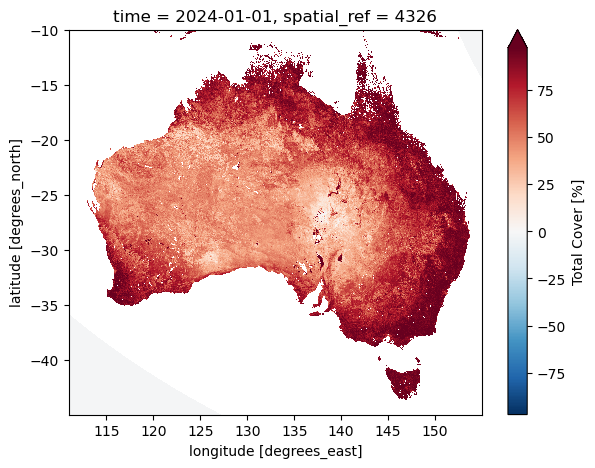

In [6]:
merged.tot_cov.isel(time=0).plot.imshow(size=5, robust=True)